In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ml_metrics import quadratic_weighted_kappa
import xgboost as xgb
import datetime as dt
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
import functools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from scipy import optimize

from xgboostmodel import XGBoostModel, ModelPrediction, DataPack

## Check the booster still works:

Made some changes to the XGBoostModel class, so that it can handle the addition of custom features as an optional parameter in the `learn_model` function:

In [2]:
def score_me(my_booster):
    return my_booster.get_scores()[['objective', 'feature_quantile_cut',
                      'custom_features', 'num_round', 'train_qwk', 'test_qwk']].sort_values(
    by='feature_quantile_cut')

In [3]:
data = pd.read_csv('csvs/data_imputed.csv')
features = data[data['train?']].drop(['train?', 'Id', 'Response'], axis=1)
labels = data[data['train?']]['Response'] - 1
submission_features = data[~data['train?']].drop(['train?', 'Id', 'Response'], axis=1)

datapack = DataPack(features, labels, submission_features)
booster = XGBoostModel(nfolds=3, datapack=datapack)

fold = 1 # the fold to use for train-test split
booster.learn_model(fold, objective='reg:linear', num_round=150, 
                    feature_quantile_cut = 0.0,
                    make_plot=False,
                    eta=0.06,
                    max_depth=9,
                    min_child_weight=150,
                    colsample_bytree=0.8,
                    subsample=0.8)
score_me(booster)

,objective,feature_quantile_cut,custom_features,num_round,train_qwk,test_qwk
0,reg:linear,0.00,None,150,0.703317,0.647975


# Study the possibility of adding custom features

In [8]:
def cf01(row):
    return (row['BMI'] * row['Ins_Age'])**2.5

def cf02(row):
    return (row['BMI'] + 1.) ** 2.0

def cf03(row):
    return row['BMI']**0.8

def cf04(row):
    return (row['BMI'] * row['Medical_Keyword_3'] + 0.5)**3.0

def cf05(row):
    return (row['BMI'] * row['Product_Info_4'])**0.9

def cf06(row):
    return row['Ins_Age']**8.5

def cf07(row):
    return row['Medical_History_15'] < 10.

def cf08(row):
    return row['Product_Info_4'] < 0.075

def cf09(row):
    return row['Product_Info_4'] == 1

In [3]:

cfs = [
    None,
    {'name': '(BMI*Age)**2.5', 'func': cf01},
    {'name': '(1+BMI)**2.0', 'func': cf02},
    {'name': 'BMI**0.8', 'func': cf03},
    {'name': '(BMI*MK5+0.5)**3.0', 'func': cf04},
    {'name': '(BMI*PI4)**0.9', 'func': cf05},
    {'name': 'AGE**8.5', 'func': cf06},
    {'name': 'MH15<10', 'func': cf07},
    {'name': 'PI4<0.075', 'func': cf08},
    {'name': 'PI4==1', 'func': cf09}    
]

for cf in cfs:
    print(cf)
    booster.learn_model(fold, objective='reg:linear', num_round=100, 
                        feature_quantile_cut=0.0,
                        custom_features=[cf],
                        make_plot=False,
                        print_qwk=True,
                        eta=0.06,
                        max_depth=9,
                        min_child_weight=150,
                        colsample_bytree=0.8,
                        subsample=0.8)

score_me(booster)

{'func': <function cf01 at 0x7f66c3a796a8>, 'name': '(BMI*Age)**2.5'}
qwktrain = 0.7053, qwktest = 0.6478
{'func': <function cf02 at 0x7f66c3a79730>, 'name': '(1+BMI)**2.0'}
qwktrain = 0.7033, qwktest = 0.6475
{'func': <function cf03 at 0x7f66c3a797b8>, 'name': 'BMI**0.8'}
qwktrain = 0.7042, qwktest = 0.6481
{'func': <function cf04 at 0x7f66c3a79840>, 'name': '(BMI*MK5+0.5)**3.0'}
qwktrain = 0.7047, qwktest = 0.6463
{'func': <function cf05 at 0x7f66c3a798c8>, 'name': '(BMI*PI4)**0.9'}
qwktrain = 0.7049, qwktest = 0.6466
{'func': <function cf06 at 0x7f66c3a79950>, 'name': 'AGE**8.5'}
qwktrain = 0.7046, qwktest = 0.6482
{'func': <function cf07 at 0x7f66c3a799d8>, 'name': 'MH15<10'}
qwktrain = 0.7046, qwktest = 0.6486
{'func': <function cf08 at 0x7f66c3a79a60>, 'name': 'PI4<0.075'}
qwktrain = 0.7036, qwktest = 0.6481
{'func': <function cf09 at 0x7f66c3a79ae8>, 'name': 'PI4==1'}
qwktrain = 0.7046, qwktest = 0.6480


,objective,feature_quantile_cut,custom_features,num_round,train_qwk,test_qwk
0,reg:linear,0.00,None,150,0.703317,0.647975
1,reg:linear,0.00,(BMI*Age)**2.5,150,0.705288,0.647817
2,reg:linear,0.00,(1+BMI)**2.0,150,0.703318,0.647530
3,reg:linear,0.00,BMI**0.8,150,0.704193,0.648060
4,reg:linear,0.00,(BMI*MK5+0.5)**3.0,150,0.704734,0.646305
5,reg:linear,0.00,(BMI*PI4)**0.9,150,0.704916,0.646586
6,reg:linear,0.00,AGE**8.5,150,0.704563,0.648238
7,reg:linear,0.00,MH15<10,150,0.704649,0.648560
8,reg:linear,0.00,PI4<0.075,150,0.703629,0.648146
9,reg:linear,0.00,PI4==1,150,0.704591,0.648048


In [4]:
cfs = [
    None,
    {'name': '(BMI*Age)**2.5', 'func': cf01},
    {'name': '(1+BMI)**2.0', 'func': cf02},
    {'name': 'BMI**0.8', 'func': cf03},
    {'name': '(BMI*MK5+0.5)**3.0', 'func': cf04},
    {'name': '(BMI*PI4)**0.9', 'func': cf05},
    {'name': 'AGE**8.5', 'func': cf06},
    {'name': 'MH15<10', 'func': cf07},
    {'name': 'PI4<0.075', 'func': cf08},
    {'name': 'PI4==1', 'func': cf09}    
]

booster.learn_model(fold, objective='reg:linear', num_round=450, 
                    feature_quantile_cut=0.0,
                    custom_features=cfs,
                    make_plot=False,
                    eta=0.06,
                    max_depth=9,
                    min_child_weight=150,
                    colsample_bytree=0.8,
                    subsample=0.8)

score_me(booster)

,objective,feature_quantile_cut,custom_features,num_round,train_qwk,test_qwk
0,reg:linear,0.00,None,150,0.703317,0.647975
1,reg:linear,0.00,(BMI*Age)**2.5,150,0.705288,0.647817
2,reg:linear,0.00,(1+BMI)**2.0,150,0.703318,0.647530
3,reg:linear,0.00,BMI**0.8,150,0.704193,0.648060
4,reg:linear,0.00,(BMI*MK5+0.5)**3.0,150,0.704734,0.646305
5,reg:linear,0.00,(BMI*PI4)**0.9,150,0.704916,0.646586
6,reg:linear,0.00,AGE**8.5,150,0.704563,0.648238
7,reg:linear,0.00,MH15<10,150,0.704649,0.648560
8,reg:linear,0.00,PI4<0.075,150,0.703629,0.648146
9,reg:linear,0.00,PI4==1,150,0.704591,0.648048


It seems clear that by adding too many features you introduce variance into the model and start overfitting. 

# Explore adding interactions between the most significant predictors

# Make a submission that uses bagging and only 3 of the best custom features

In [ ]:
data = pd.read_csv('csvs/data_imputed.csv')
features = data[data['train?']].drop(['train?', 'Id', 'Response'], axis=1)
labels = data[data['train?']]['Response'] - 1
submission_features = data[~data['train?']].drop(['train?', 'Id', 'Response'], axis=1)

datapack = DataPack(features, labels, submission_features)
booster = XGBoostModel(nfolds=3, datapack=datapack)


for fold in range(3):
    booster.learn_model(fold, objective='multi:softmax', num_round=250, 
                        make_plot=False,
                        print_qwk=True,
                        eta=0.06,
                        max_depth=8,
                        min_child_weight=50,
                        colsample_bytree=0.8,
                        subsample=0.8)



In [6]:
booster.get_scores()[['objective', 'fold_str', 'train_qwk', 'test_qwk']]

,objective,fold_str,train_qwk,test_qwk
0,multi:softmax,CV0,0.611047,0.554769
1,multi:softmax,CV1,0.615971,0.550655
2,multi:softmax,CV2,0.617287,0.558901


In [11]:
cfs = [
    None,
    {'name': 'AGE**8.5', 'func': cf06},
    {'name': 'MH15<10', 'func': cf07},
    {'name': 'PI4<0.075', 'func': cf08},  
]

for cf in cfs:
    if cf is not None:
        cf = [cf]
    for fold in range(3):
        booster.learn_model(fold, objective='reg:linear', num_round=250, 
                            feature_quantile_cut=0.0,
                            custom_features=cf,
                            make_plot=False,
                            print_qwk=True,
                            eta=0.06,
                            max_depth=9,
                            min_child_weight=150,
                            colsample_bytree=0.8,
                            subsample=0.8)

qwktrain = 0.7235, qwktest = 0.6570
qwktrain = 0.7268, qwktest = 0.6495
qwktrain = 0.7216, qwktest = 0.6607
qwktrain = 0.7220, qwktest = 0.6548
qwktrain = 0.7269, qwktest = 0.6496
qwktrain = 0.7216, qwktest = 0.6585
qwktrain = 0.7221, qwktest = 0.6558
qwktrain = 0.7277, qwktest = 0.6481
qwktrain = 0.7211, qwktest = 0.6592
qwktrain = 0.7226, qwktest = 0.6578
qwktrain = 0.7256, qwktest = 0.6497
qwktrain = 0.7203, qwktest = 0.6591


## From all of the reg:linear models in the bag, get an estimate of the best cuts

In [20]:
from xgboostmodel import optimize_cutoffs

cuts_train = []
cuts_test = []

for m in zip(booster.models, booster.scores):
    model, fold, pred = m[0]
    score = m[1] 
    
    
    if score['objective'] == 'reg:linear':
        print("="*80)
        best_cuts = optimize_cutoffs(pred.ystrain, pred.ytrain, verbose=True)
        print(best_cuts)
        cuts_train.append(best_cuts)
        print("-"*80)
        best_cuts = optimize_cutoffs(pred.ystest, pred.ytest, verbose=True)
        print(best_cuts)
        cuts_test.append(best_cuts)
        

    start error : 0.32990382985897226
Optimization terminated successfully.
         Current function value: 0.276525
         Iterations: 10
         Function evaluations: 1009
    final error : 0.27652483707468534

[ 1.92940658  2.64457134  3.28874792  3.8417392   4.42803569  5.12930852
  5.90447275]
--------------------------------------------------------------------------------
    start error : 0.3925172658817011
Optimization terminated successfully.
         Current function value: 0.340347
         Iterations: 9
         Function evaluations: 857
    final error : 0.3403467658155591

[ 1.92552349  2.75287552  3.41213575  3.77565006  4.44104437  5.33490194
  5.7715216 ]
    start error : 0.325744831430242
Optimization terminated successfully.
         Current function value: 0.273198
         Iterations: 11
         Function evaluations: 1168
    final error : 0.27319803417191835

[ 1.79632704  2.63889829  3.31170679  3.9309512   4.4999581   5.25546019
  5.81897632]
-------------

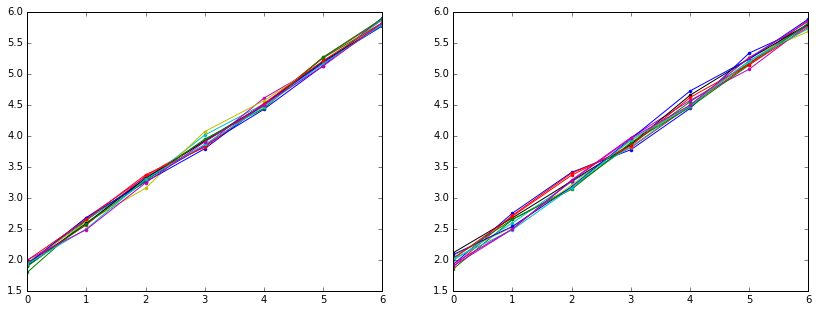

In [21]:
fig, ax = plt.subplots(1,2, figsize=(14., 5.))

for cut in cuts_train:
    ax[0].plot(cut, '.-')
    
for cut in cuts_test:
    ax[1].plot(cut, '.-')
    

In [25]:
np.vstack(cuts_train).mean(axis=0)

array([ 1.9280829 ,  2.60604096,  3.289103  ,  3.90200344,  4.50427461,
        5.19231188,  5.83065852])

In [27]:
np.vstack(cuts_test).mean(axis=0)

array([ 1.98630411,  2.60789148,  3.25994142,  3.88238997,  4.53757232,
        5.20548059,  5.79518926])

In [31]:
my_best_cuts = np.vstack(cuts_train + cuts_test).mean(axis=0)
my_best_cuts

array([ 1.95719351,  2.60696622,  3.27452221,  3.8921967 ,  4.52092346,
        5.19889624,  5.81292389])

In [43]:
from combopredict import ComboPredict

combo = ComboPredict(booster)
overall_cls_factor = 0.4
yhcombo = combo.predict_categories(submission_features, overall_cls_factor, my_best_cuts)

submission_ids = data[data['train?'] == False]['Id']
submission_df = pd.DataFrame({"Id": submission_ids, 
                              "Response": yhcombo.astype('int') + 1})

submission_df = submission_df.set_index('Id')
submission_df.to_csv('step05_submission_01.csv')

submission_df.describe()

(19765, 1)
(19765, 1)
(19765, 1)
(19765, 1)
(19765, 1)
(19765, 1)
(19765, 1)
(19765, 1)
(19765, 1)
(19765, 1)
(19765, 1)
(19765, 1)
(19765, 1)
(19765, 1)
(19765, 1)


,Response
count,19765.000000
mean,5.654895
std,2.280753
min,1.000000
25%,4.000000
50%,6.000000
75%,8.000000
max,8.000000
